In [3]:
# --- PART 1: IMPORTS & LOAD DATA ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set style
sns.set(style="whitegrid")

# Load the datasets
customer_df = pd.read_excel("Customer_Info_2025.xlsx")
spending_df = pd.read_excel("Spending_Info_2025.xlsx")


In [5]:
# --- PART 2: PREPROCESSING ---

# Clean column names
spending_df['SpendingType'] = spending_df['SpendingType'].str.strip().str.lower()
customer_df.columns = [col.strip() for col in customer_df.columns]

# View unique categories (optional check)
print(spending_df['SpendingType'].unique())


['electronics' 'groceries' 'miscellaneous' 'clothing' 'tourism'
 'automobile' 'cosmetics' 'cash withdrawal' 'education' 'furniture'
 'travel' 'white appliances' 'gasoline' 'tax spendings']


In [7]:
# --- PART 3: AGGREGATE SPENDING & MERGE WITH CUSTOMER DATA ---

# Pivot the data to get total spent by category per customer
agg_spending = spending_df.groupby(['IABCustomerNo', 'SpendingType'])['SpentAmount'].sum().unstack(fill_value=0)
agg_spending.reset_index(inplace=True)

# Merge with customer info
merged_df = pd.merge(customer_df, agg_spending, on='IABCustomerNo', how='left')
merged_df.fillna(0, inplace=True)  # fill NA values with 0s


In [9]:
# --- PART 4: DEFINE ELIGIBLE CUSTOMERS FOR CAMPAIGN ---

# Spending column names
spending_cols = agg_spending.columns.drop('IABCustomerNo')
other_categories = [col for col in spending_cols if col not in ['groceries', 'gasoline']]

# Compute aggregated features
merged_df['OtherSpending'] = merged_df[other_categories].sum(axis=1)
merged_df['GroceriesAndFuel'] = merged_df['groceries'] + merged_df['gasoline']

# Eligibility criteria:
merged_df['Eligible'] = (
    (merged_df['OtherSpending'] >= 1000) &
    (merged_df['GroceriesAndFuel'] < 500) &
    (merged_df['SMSCommPermit'] == 1)
)

# Filter eligible customers
eligible_customers = merged_df[merged_df['Eligible']]


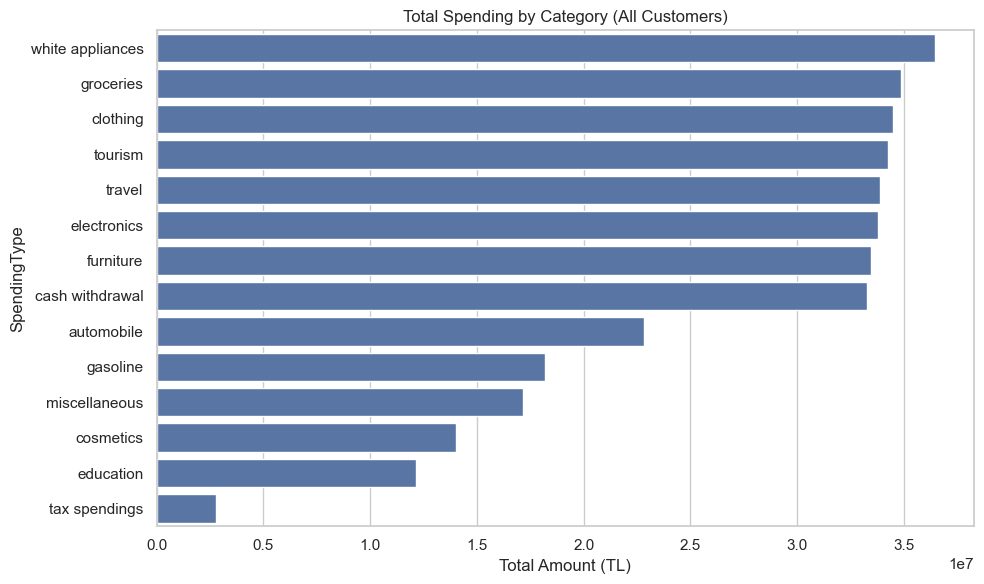

In [11]:
# --- PART 5: TOTAL SPENDING PER CATEGORY ---

total_by_category = spending_df.groupby('SpendingType')['SpentAmount'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=total_by_category.values, y=total_by_category.index)
plt.title('Total Spending by Category (All Customers)')
plt.xlabel('Total Amount (TL)')
plt.tight_layout()
plt.show()


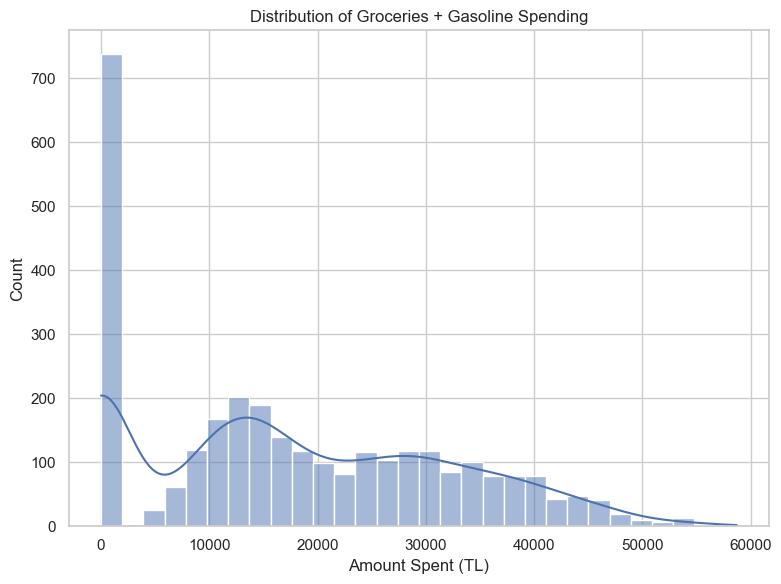

In [13]:
# --- PART 6: HISTOGRAM OF GROCERIES + GASOLINE SPENDING ---

plt.figure(figsize=(8, 6))
sns.histplot(merged_df['GroceriesAndFuel'], bins=30, kde=True)
plt.title('Distribution of Groceries + Gasoline Spending')
plt.xlabel('Amount Spent (TL)')
plt.tight_layout()
plt.show()


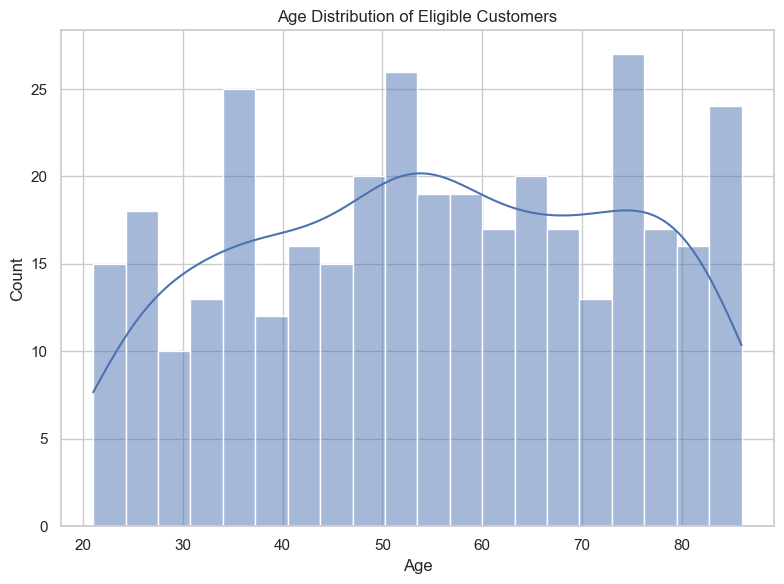

In [19]:
# --- PART 8: AGE DISTRIBUTION (CORRECTED) ---

# Ensure BirthY is numeric and not missing
merged_df = merged_df[merged_df['BirthY'].notnull()]
merged_df['BirthY'] = pd.to_numeric(merged_df['BirthY'], errors='coerce')

# Recalculate age
merged_df['Age'] = 2025 - merged_df['BirthY']
eligible_customers = merged_df[merged_df['Eligible']]  # refresh eligible customers

# Plot the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(eligible_customers['Age'], bins=20, kde=True)
plt.title('Age Distribution of Eligible Customers')
plt.xlabel('Age')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

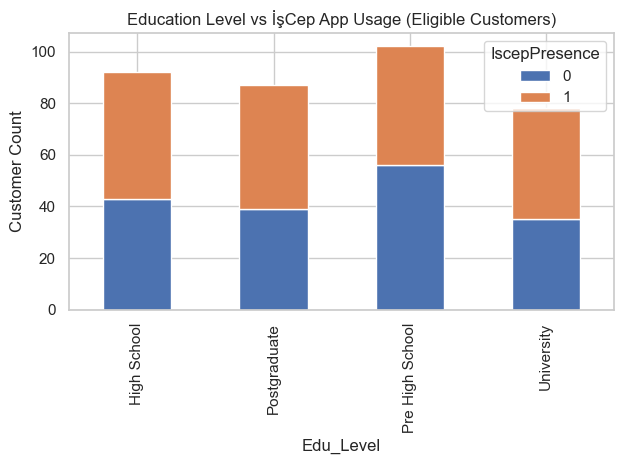

In [21]:
# --- PART 9: EDUCATION LEVEL VS ISCEP APP USAGE ---

edu_app_summary = eligible_customers.groupby(['Edu_Level', 'IscepPresence']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
edu_app_summary.plot(kind='bar', stacked=True)
plt.title('Education Level vs İşCep App Usage (Eligible Customers)')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

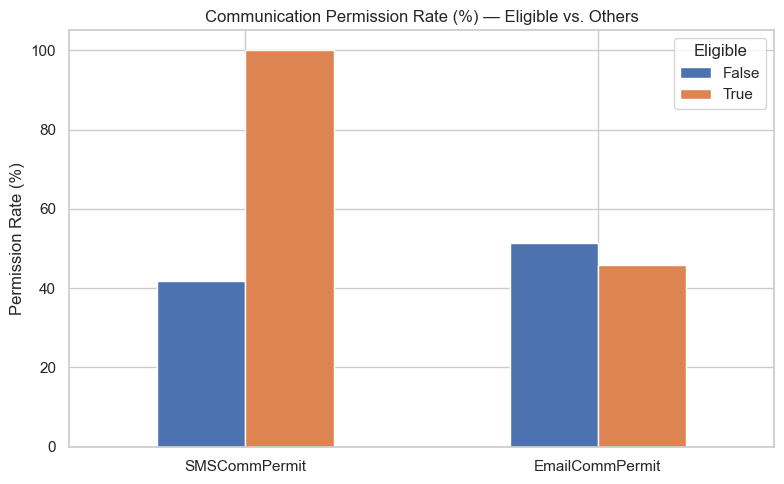

In [23]:
# --- PART 10: Communication Channel Permissions ---

comm_perm_summary = merged_df.groupby('Eligible')[['SMSCommPermit', 'EmailCommPermit']].mean() * 100

plt.figure(figsize=(8, 5))
comm_perm_summary.T.plot(kind='bar', figsize=(8, 5))
plt.title('Communication Permission Rate (%) — Eligible vs. Others')
plt.ylabel('Permission Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


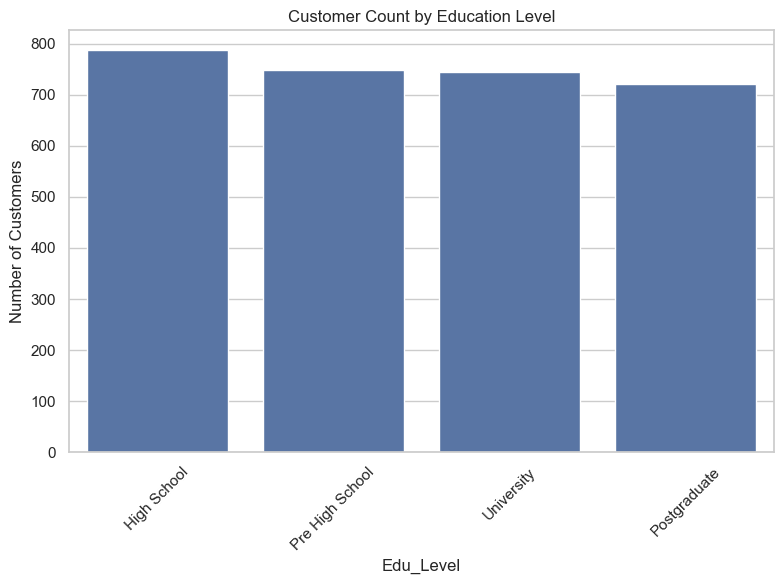

In [33]:
# --- BAR CHART: EDUCATION DISTRIBUTION ---

edu_counts = merged_df['Edu_Level'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=edu_counts.index, y=edu_counts.values)
plt.title('Customer Count by Education Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


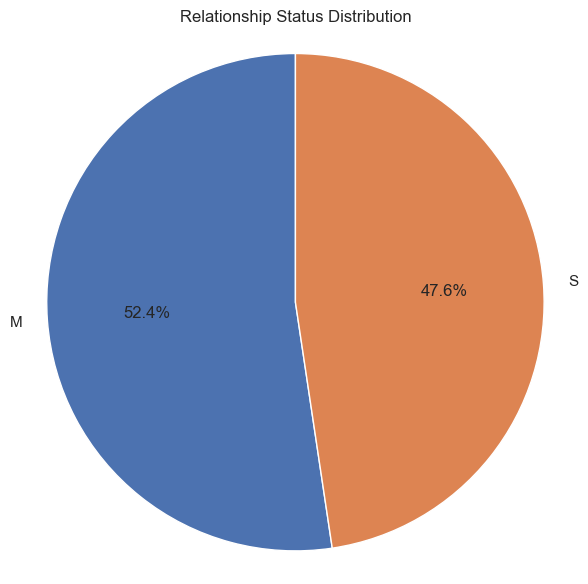

In [35]:
# --- PIE CHART: RELATIONSHIP STATUS ---

rel_counts = merged_df['RelationshipStatus'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(rel_counts, labels=rel_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Relationship Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()


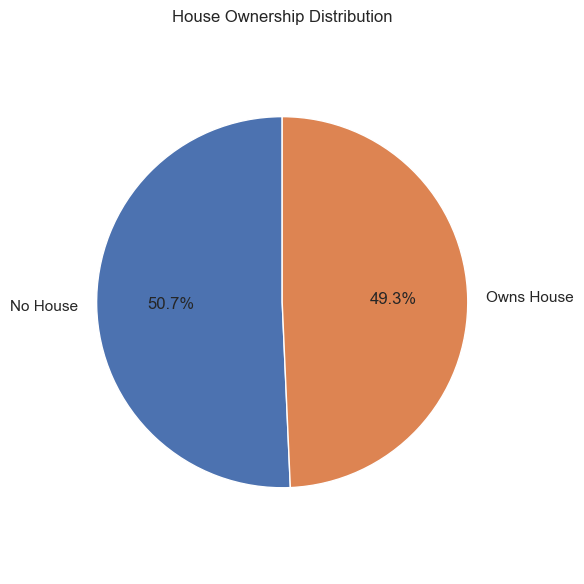

In [37]:
# --- PIE CHART: HOUSE OWNERSHIP ---

house_own_counts = merged_df['HouseOwnership'].value_counts()
labels = ['No House', 'Owns House']

plt.figure(figsize=(6, 6))
plt.pie(house_own_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('House Ownership Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


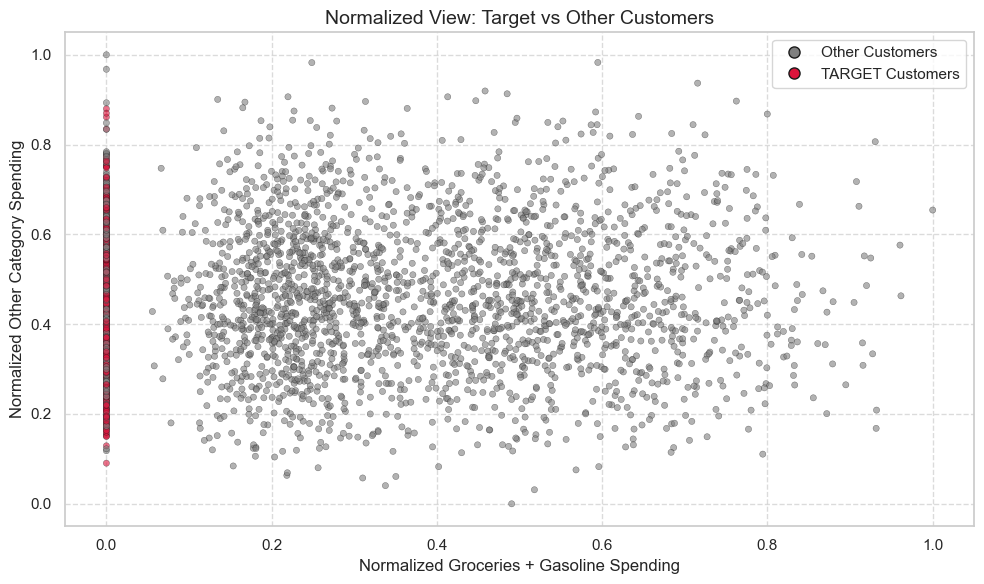

In [49]:
# Min-max normalization
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

merged_df['norm_groceryfuel'] = normalize(merged_df['grocery_fuel_total'])
merged_df['norm_other'] = normalize(merged_df['other_total'])

plt.figure(figsize=(10, 6))
colors = merged_df['target_flag'].map({0: 'gray', 1: 'crimson'})

plt.scatter(
    merged_df['norm_groceryfuel'],
    merged_df['norm_other'],
    c=colors,
    alpha=0.6,
    edgecolors='k',
    linewidths=0.3,
    s=20
)

plt.title("Normalized View: Target vs Other Customers", fontsize=14)
plt.xlabel("Normalized Groceries + Gasoline Spending", fontsize=12)
plt.ylabel("Normalized Other Category Spending", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend(handles=legend_elements, loc='upper right')
plt.show()


In [51]:
# --- PART 10: EXPORT FINAL ELIGIBLE CUSTOMER LIST ---

eligible_customers[['IABCustomerNo', 'Monthly_Income', 'groceries', 'gasoline', 'OtherSpending']].to_excel("Eligible_Customers_For_Campaign.xlsx", index=False)
